In [1]:
import os
import numpy as np
import shutil
import glob
import csv
import cv2 as cv
import nibabel as nib
import matplotlib.pyplot as plt
from genericpath import exists
from typing import Sized
from matplotlib.figure import Figure
import json
from PIL import Image
import pandas as pd
from skimage import color
from skimage import io
from scipy.signal import correlate
from scipy.stats import multivariate_normal
import pandas as pd
from scipy.stats import kurtosis, skew, entropy, median_absolute_deviation
import warnings
import scipy.optimize
import seaborn as sns
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

# Data Loading

In [2]:
df = pd.read_csv(r'D:\OneDrive\JOB\NUXTU\Casos_positivos_de_COVID-19_en_Colombia.csv')
df.head()

,fecha reporte web,ID de caso,Fecha de notificación,Código DIVIPOLA departamento,Nombre departamento,Código DIVIPOLA municipio,Nombre municipio,Edad,Unidad de medida de edad,Sexo,...,Código ISO del país,Nombre del país,Recuperado,Fecha de inicio de síntomas,Fecha de muerte,Fecha de diagnóstico,Fecha de recuperación,Tipo de recuperación,Pertenencia étnica,Nombre del grupo étnico
0,2021-03-04 00:00:00,2265685,2021-03-02 00:00:00,11,BOGOTA,11001,BOGOTA,49,1,M,...,NaN,NaN,Recuperado,2021-02-25 00:00:00,NaN,2021-03-03 00:00:00,2021-03-16 00:00:00,Tiempo,6.0,NaN
1,2021-03-04 00:00:00,2265686,2021-03-02 00:00:00,11,BOGOTA,11001,BOGOTA,49,1,M,...,NaN,NaN,Recuperado,2021-02-23 00:00:00,NaN,2021-03-03 00:00:00,2021-03-16 00:00:00,Tiempo,6.0,NaN
2,2021-03-04 00:00:00,2265687,2021-03-02 00:00:00,11,BOGOTA,11001,BOGOTA,51,1,F,...,NaN,NaN,Recuperado,2021-02-24 00:00:00,NaN,2021-03-03 00:00:00,2021-03-16 00:00:00,Tiempo,6.0,NaN
3,2021-03-04 00:00:00,2265688,2021-03-02 00:00:00,11,BOGOTA,11001,BOGOTA,51,1,F,...,NaN,NaN,Recuperado,2021-02-27 00:00:00,NaN,2021-03-03 00:00:00,2021-03-13 00:00:00,Tiempo,6.0,NaN
4,2021-03-04 00:00:00,2265689,2021-03-02 00:00:00,11,BOGOTA,11001,BOGOTA,51,1,F,...,NaN,NaN,Recuperado,2021-03-01 00:00:00,NaN,2021-03-03 00:00:00,2021-03-16 00:00:00,Tiempo,6.0,NaN


In [3]:
print(df.shape)
print(df.columns)

(6247634, 23)
Index(['fecha reporte web', 'ID de caso', 'Fecha de notificación',
       'Código DIVIPOLA departamento', 'Nombre departamento',
       'Código DIVIPOLA municipio', 'Nombre municipio', 'Edad',
       'Unidad de medida de edad', 'Sexo', 'Tipo de contagio',
       'Ubicación del caso', 'Estado', 'Código ISO del país',
       'Nombre del país', 'Recuperado', 'Fecha de inicio de síntomas',
       'Fecha de muerte', 'Fecha de diagnóstico', 'Fecha de recuperación',
       'Tipo de recuperación', 'Pertenencia étnica',
       'Nombre del grupo étnico'],
      dtype='object')


# Exploratory Data Analysis

The following lines allow to explore columns in the dataset, their values, data type, null entries and how unique values are distributed among columns in order to check if any column can be dropped out due to its entries. First, the "Estado" column which is the subject of prediction is explored

In [4]:
print('Null values:', df.Estado.isnull().sum())
df.Estado.value_counts()

Null values: 30484


Leve         6025656
Fallecido     140603
leve           49905
Moderado         908
Grave             76
LEVE               2
Name: Estado, dtype: int64

In [5]:
df[df['Estado']=='LEVE'] = 'Leve'
df[df['Estado']=='leve'] = 'Leve'
df.Estado.value_counts()

Leve         6075563
Fallecido     140603
Moderado         908
Grave             76
Name: Estado, dtype: int64

Unique labels are:
- Leve: 6075563
- Moderado: 908 entries
- Grave: 76 entries
- Fallecido: 140603 entries
With Nan: 30483 entries

Further preprocessing will require joining 'Leve', 'leve' and 'LEVE' as unique values. The above result shows that classes are unbalanced since ‘leve’ have more than 6 million entries while grave have only 76. This will be an important insight during training. 


According to the INS, empty "Recuperado" entries are "active" entries, therefore:

In [6]:
df.Recuperado = df.Recuperado.fillna('Activo')
df[df['Recuperado']=='fallecido'] = 'Fallecido'
df.Recuperado.value_counts()

Recuperado    6003952
Fallecido      140603
Activo          53172
Leve            49907
Name: Recuperado, dtype: int64

Useful information can be displaied of all columns in order to verify their data type and null entries

In [7]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6247634 entries, 0 to 6247633
Data columns (total 23 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   fecha reporte web             6247634 non-null  object
 1   ID de caso                    6247634 non-null  object
 2   Fecha de notificación         6247634 non-null  object
 3   Código DIVIPOLA departamento  6247634 non-null  object
 4   Nombre departamento           6247634 non-null  object
 5   Código DIVIPOLA municipio     6247634 non-null  object
 6   Nombre municipio              6247634 non-null  object
 7   Edad                          6247634 non-null  object
 8   Unidad de medida de edad      6247634 non-null  object
 9   Sexo                          6247634 non-null  object
 10  Tipo de contagio              6247634 non-null  object
 11  Ubicación del caso            6217150 non-null  object
 12  Estado                        6217150 non-

All columns are imported as object dtype so further data type adjustment is required. The above results reveal that four columns have null or NaN data for most of their entries. These are:

- Código ISO del país
- Nombre del país
- Fecha de muerte
- Nombre del grupo étinco

To assess if deleting those features will negatively impact our model, unique values, and their value count for each is useful. To visualize the full output, select "in a text editor".


In [8]:
col = 'Código ISO del país'
print(df[col].value_counts().shape)
pd.options.display.max_rows = 6000
# df[col].value_counts()


(100,)


In [9]:
col = 'Nombre del país'
print(df[col].value_counts().shape)
# df[col].value_counts()


(90,)


In [10]:
df['Nombre del país'].notnull().sum(), df['Código ISO del país'].notnull().sum() 

(53899, 53891)

Since "Nombre del país" and "Código ISO del país" provide the same information and the latter have more non-null entries, "Nombre del país" can be deleted as a feature. The same is true for "Código DIVIPOLA..." of municipalities and departments and the columns with their names. Since codes are unique and names in lower and upper caps are detected as different entries, columns with names of municipalities and departments are deleted while DIVIPOLA codes are kept, since they contain the similar information.

In [11]:
df = df.drop('Nombre del país', axis = 1)
df.shape, df.columns

((6247634, 22),
 Index(['fecha reporte web', 'ID de caso', 'Fecha de notificación',
        'Código DIVIPOLA departamento', 'Nombre departamento',
        'Código DIVIPOLA municipio', 'Nombre municipio', 'Edad',
        'Unidad de medida de edad', 'Sexo', 'Tipo de contagio',
        'Ubicación del caso', 'Estado', 'Código ISO del país', 'Recuperado',
        'Fecha de inicio de síntomas', 'Fecha de muerte',
        'Fecha de diagnóstico', 'Fecha de recuperación', 'Tipo de recuperación',
        'Pertenencia étnica', 'Nombre del grupo étnico'],
       dtype='object'))

In [12]:
print(df['Código DIVIPOLA departamento'].value_counts().shape, df['Nombre departamento'].value_counts().shape)
print(df['Código DIVIPOLA departamento'].value_counts().sum(), df['Nombre departamento'].value_counts().sum())

df = df.drop('Nombre departamento', axis = 1)
df.shape, df.columns

(38,) (42,)
6247634 6247634


((6247634, 21),
 Index(['fecha reporte web', 'ID de caso', 'Fecha de notificación',
        'Código DIVIPOLA departamento', 'Código DIVIPOLA municipio',
        'Nombre municipio', 'Edad', 'Unidad de medida de edad', 'Sexo',
        'Tipo de contagio', 'Ubicación del caso', 'Estado',
        'Código ISO del país', 'Recuperado', 'Fecha de inicio de síntomas',
        'Fecha de muerte', 'Fecha de diagnóstico', 'Fecha de recuperación',
        'Tipo de recuperación', 'Pertenencia étnica',
        'Nombre del grupo étnico'],
       dtype='object'))

In [13]:
print(df['Código DIVIPOLA municipio'].value_counts().shape, df['Nombre municipio'].value_counts().shape)
print(df['Código DIVIPOLA municipio'].value_counts().sum(), df['Nombre municipio'].value_counts().sum())

df = df.drop('Nombre municipio', axis = 1)
df.shape, df.columns

(1123,) (1055,)
6247634 6247634


((6247634, 20),
 Index(['fecha reporte web', 'ID de caso', 'Fecha de notificación',
        'Código DIVIPOLA departamento', 'Código DIVIPOLA municipio', 'Edad',
        'Unidad de medida de edad', 'Sexo', 'Tipo de contagio',
        'Ubicación del caso', 'Estado', 'Código ISO del país', 'Recuperado',
        'Fecha de inicio de síntomas', 'Fecha de muerte',
        'Fecha de diagnóstico', 'Fecha de recuperación', 'Tipo de recuperación',
        'Pertenencia étnica', 'Nombre del grupo étnico'],
       dtype='object'))

For 'Fecha de muerte', further feature extraction/selection analysis will provide more insights on how useful it will be for our model since most of its entries are null.

An inspection through the unique entries in "Nombre del grupo étnico" revealed that some misleading information was found since some entries are cities, numbers, dates, neighbours, but not ethnical groups, e.g., entries like "LA PAZ", "13 DE MAYO", etc. Therefore, this column will be droped as feature for the models.

In [14]:
col = 'Nombre del grupo étnico'
print(df[col].value_counts().size)
# df[col].value_counts()

1855


In [15]:
df = df.drop('Nombre del grupo étnico', axis = 1)
df.shape, df.columns

((6247634, 19),
 Index(['fecha reporte web', 'ID de caso', 'Fecha de notificación',
        'Código DIVIPOLA departamento', 'Código DIVIPOLA municipio', 'Edad',
        'Unidad de medida de edad', 'Sexo', 'Tipo de contagio',
        'Ubicación del caso', 'Estado', 'Código ISO del país', 'Recuperado',
        'Fecha de inicio de síntomas', 'Fecha de muerte',
        'Fecha de diagnóstico', 'Fecha de recuperación', 'Tipo de recuperación',
        'Pertenencia étnica'],
       dtype='object'))

Checking for useful patterns in all columns, 49907 rows have 'Leve' as entry and 295 have 'Fallecido' as entry in all columns in the dataframe, therefore, these rows will be deleted from the dataset.

In [16]:
# Change the col variable to explore "Leve" and "Fallecido" presence in other columns
col = 'Pertenencia étnica'
print(df[col].value_counts().size)
df[col].value_counts()

7


6.0          5954974
5.0           135952
1.0            81837
Leve           49907
3.0              405
Fallecido        295
2.0              133
Name: Pertenencia étnica, dtype: int64

In [17]:
df = df[df['Pertenencia étnica'] != 'Leve']
df = df[df['Pertenencia étnica'] != 'Fallecido']

col = 'Pertenencia étnica'
print(df[col].value_counts().size)
df[col].value_counts()

5


6.0    5954974
5.0     135952
1.0      81837
3.0        405
2.0        133
Name: Pertenencia étnica, dtype: int64

In [18]:
df.describe()

,fecha reporte web,ID de caso,Fecha de notificación,Código DIVIPOLA departamento,Código DIVIPOLA municipio,Edad,Unidad de medida de edad,Sexo,Tipo de contagio,Ubicación del caso,Estado,Código ISO del país,Recuperado,Fecha de inicio de síntomas,Fecha de muerte,Fecha de diagnóstico,Fecha de recuperación,Tipo de recuperación,Pertenencia étnica
count,6197432,6197432,6197432,6197432,6197432,6197432,6197432,6197432,6197432,6166948,6166948,3689.0,6197432,5699138,170792,6194677,6003952,6003952,6173301.0
unique,795,6197432,868,36,1121,114,3,4,3,6,4,98.0,3,873,855,864,856,2,5.0
top,2022-01-15 00:00:00,1,2022-01-06 00:00:00,11,11001,30,1,F,Comunitaria,Casa,Leve,840.0,Recuperado,2022-01-03 00:00:00,2021-06-21 00:00:00,2022-01-07 00:00:00,2021-06-15 00:00:00,Tiempo,6.0
freq,35558,1,42640,1822915,1822915,149695,6171721,3305836,4287894,6021502,6025656,1415.0,6003952,37300,716,39621,61034,5076095,5954974.0


For Age to be a reliable feature all entries must have the same time unit. Therefore, months and days entries will be converted to years since the mayority of entries have this unit of meassure.

In [19]:
# For entries in months
new_age2 = df.loc[df['Unidad de medida de edad']==2, ['Edad']].iloc[:,0]/12
df.loc[df['Unidad de medida de edad']==2, ['Edad']] = new_age2

# For entries in days
new_age3 = df.loc[df['Unidad de medida de edad']==3, ['Edad']].iloc[:,0]/365
df.loc[df['Unidad de medida de edad']==3, ['Edad']] = new_age3

# # drop "unidad de medida de edad" since no longer useful
# df = df.drop('Unidad de medida de edad', axis = 1)
# df.shape

In [20]:
# Defining unique entries for 'Sexo'
df.loc[df.Sexo == 'm', ['Sexo']] = 'M'
df.loc[df.Sexo == 'f',['Sexo']] = 'F'

df.Sexo.value_counts()

F    3305842
M    2891590
Name: Sexo, dtype: int64

## EDA for each label

### Age

From the plot bellow three conclusion can be drawn:
- Most of the people in the data set have slight (Leve) or deceased (fallecido) states. Slight distribution is right skewed with mean near 39 years old, hence given that a patient is in a slight COVID19 state, it is more likely that is between 20 and 55 years old, since more people in this range age are labeled under this class. On the other hand, deceased patients have mean 68.33 with a left skewed distribution, hence if a patient has deceased it is more likely that he/she was above 50 years old have.
- Less people are moderate (moderado) or serious (grave) with sparser distributions, with big interquartile ranges. Both distributions have a high number of kids and babies however, ignoring toddlers, both distributions are left skewed. Therefore, given that a patient is in a moderate or serious COVID19 state, it is more probable that the patient is a kid, newborn, or 50-year-old or more.


87.0 47.0
63.0 19.0


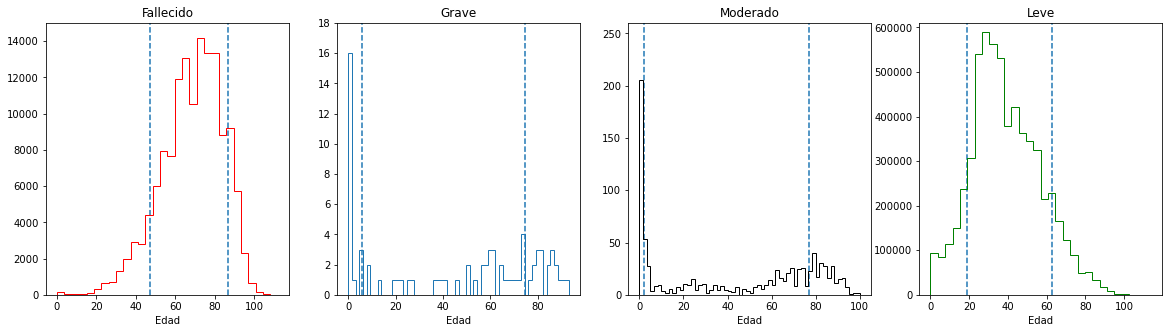

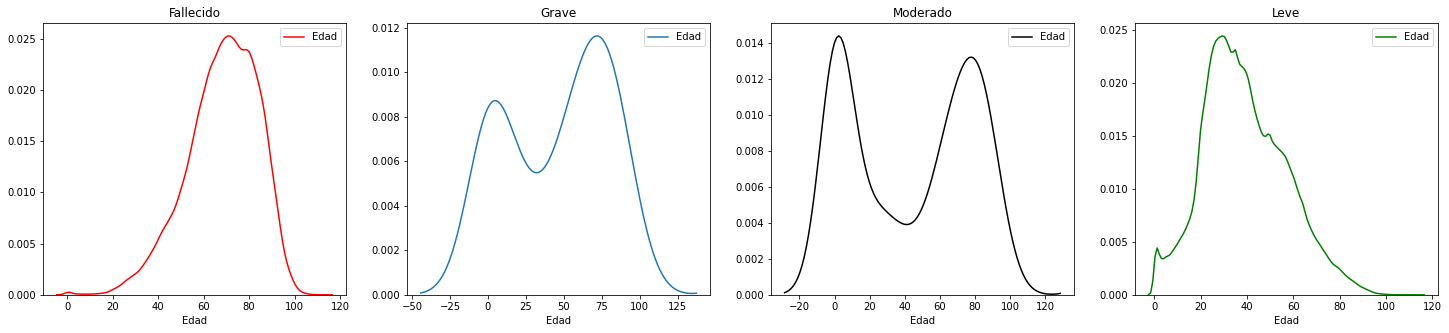

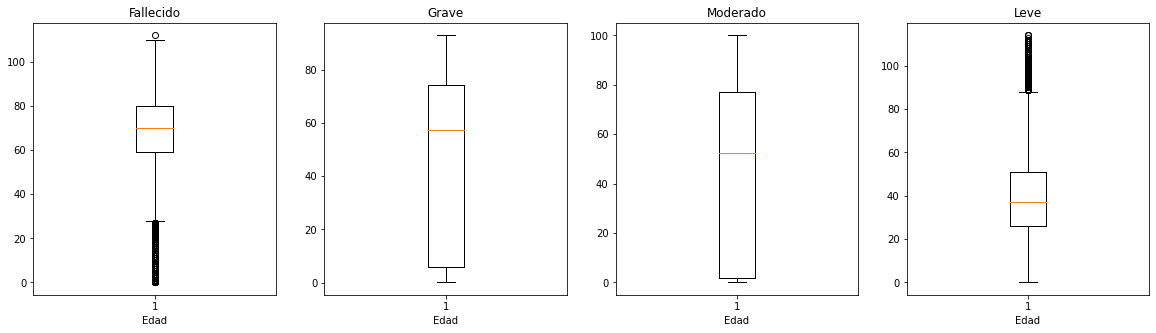

In [21]:
df.Edad = df.Edad.astype('float')

fig, axs = plt.subplots(1, 4, figsize=(20,5))
axs[0].hist(df[df['Estado']=='Fallecido'].Edad, bins=30, color='r', histtype = 'step', stacked=True)
q3, q1 = np.percentile(df[df['Estado']=='Fallecido'].Edad, [90,10])
print(q3,q1)
axs[0].vlines([q1,q3],0,15000, linestyle='dashed')
axs[0].set_title('Fallecido')
axs[0].set_xlabel('Edad')
axs[0].set_ylim(0,15000)
axs[1].hist(df[df['Estado']=='Grave'].Edad, bins=60, histtype = 'step')
q3, q1 = np.percentile(df[df['Estado']=='Grave'].Edad, [75,25])
axs[1].vlines([q1,q3],0,20, linestyle='dashed')
axs[1].set_title('Grave')
axs[1].set_xlabel('Edad')
axs[1].set_ylim(0,18)
axs[2].hist(df[df['Estado']=='Moderado'].Edad, bins=60, histtype = 'step', color='k')
q3, q1 = np.percentile(df[df['Estado']=='Moderado'].Edad, [75,25])
axs[2].vlines([q1,q3],0,300, linestyle='dashed')
axs[2].set_title('Moderado')
axs[2].set_xlabel('Edad')
axs[2].set_ylim(0,260)
axs[3].hist(df[df['Estado']=='Leve'].Edad, bins=30, histtype = 'step', color='g')
q3, q1 = np.percentile(df[df['Estado']=='Leve'].Edad, [90,10])
print(q3,q1)
axs[3].vlines([q1,q3],0,610000, linestyle='dashed')
axs[3].set_title('Leve')
axs[3].set_xlabel('Edad')
axs[3].set_ylim(0,610000)
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(25,5))
sns.kdeplot(df[df['Estado']=='Fallecido'].Edad, ax=axs[0], color='r')
axs[0].set_title('Fallecido')
axs[0].set_xlabel('Edad')
sns.kdeplot(df[df['Estado']=='Grave'].Edad, ax=axs[1])
axs[1].set_title('Grave')
axs[1].set_xlabel('Edad')
sns.kdeplot(df[df['Estado']=='Moderado'].Edad, ax=axs[2], color='k')
axs[2].set_title('Moderado')
axs[2].set_xlabel('Edad')
sns.kdeplot(df[df['Estado']=='Leve'].Edad, ax=axs[3], color='g')
axs[3].set_title('Leve')
axs[3].set_xlabel('Edad')
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(20,5))
axs[0].boxplot(df[df['Estado']=='Fallecido'].Edad)
axs[0].set_title('Fallecido')
axs[0].set_xlabel('Edad')
axs[1].boxplot(df[df['Estado']=='Grave'].Edad)
axs[1].set_title('Grave')
axs[1].set_xlabel('Edad')
axs[2].boxplot(df[df['Estado']=='Moderado'].Edad)
axs[2].set_title('Moderado')
axs[2].set_xlabel('Edad')
axs[3].boxplot(df[df['Estado']=='Leve'].Edad)
axs[3].set_title('Leve')
axs[3].set_xlabel('Edad')
plt.show()


### Gender

There is no clear tendency or relation between Gender and the state of the patient. Further feature engineering will help assess the relevance of this column.

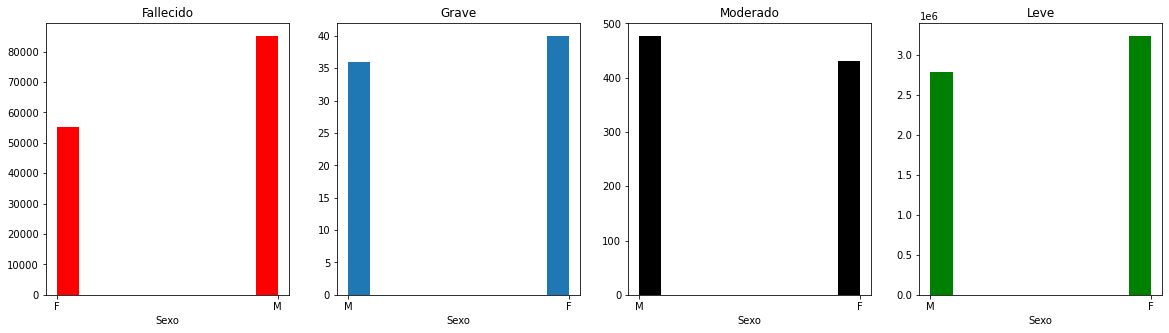

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
axs[0].hist(df[df['Estado']=='Fallecido'].Sexo, color = 'r')
axs[0].set_title('Fallecido')
axs[0].set_xlabel('Sexo')
axs[1].hist(df[df['Estado']=='Grave'].Sexo)
axs[1].set_title('Grave')
axs[1].set_xlabel('Sexo')
axs[2].hist(df[df['Estado']=='Moderado'].Sexo, color = 'k')
axs[2].set_title('Moderado')
axs[2].set_xlabel('Sexo')
axs[3].hist(df[df['Estado']=='Leve'].Sexo, color = 'g')
axs[3].set_title('Leve')
axs[3].set_xlabel('Sexo')
plt.show()

### Ethnicity

Most of the patients in all states are classified as other etnicity among the 6 classess available. This night be a consequence lack of etnicity awareness in some populaitons as well as low access to test and health care systems in some ethnicities, which can bias data. Also, a lot of ethnicities are minorities hence, lower recordings are expected. Therefore, it is likely that this column will not be a useful feture in predicting the state of a patient, but further feature analysis will give more insights.

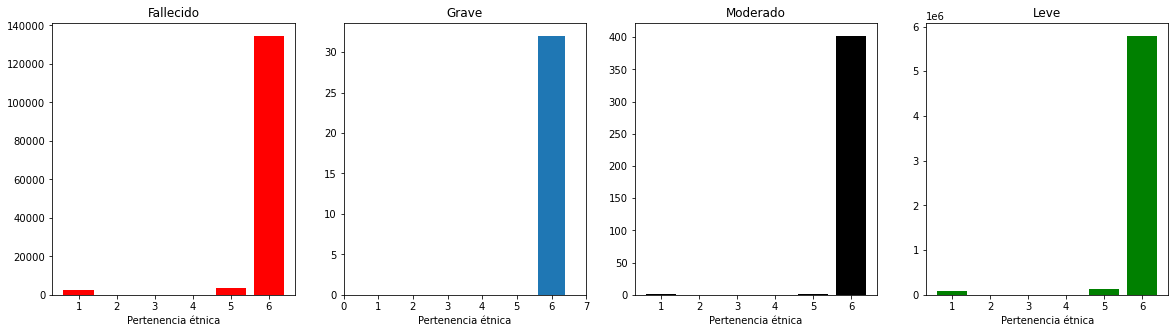

In [23]:
df['Pertenencia étnica'] = df['Pertenencia étnica'].astype('float')

fig, axs = plt.subplots(1, 4, figsize=(20,5))
axs[0].bar(df[df['Estado']=='Fallecido']['Pertenencia étnica'].value_counts().sort_index().index, df[df['Estado']=='Fallecido']['Pertenencia étnica'].value_counts().sort_index(),\
     color = 'r', align='center')
axs[0].set_title('Fallecido')
axs[0].set_xlabel('Pertenencia étnica')
axs[1].bar(df[df['Estado']=='Grave']['Pertenencia étnica'].value_counts().sort_index().index, df[df['Estado']=='Grave']['Pertenencia étnica'].value_counts().sort_index(), align='center')
axs[1].set_title('Grave')
axs[1].set_xlabel('Pertenencia étnica')
axs[1].set_xlim([0,7])
axs[2].bar(df[df['Estado']=='Moderado']['Pertenencia étnica'].value_counts().sort_index().index,df[df['Estado']=='Moderado']['Pertenencia étnica'].value_counts().sort_index(),\
     color = 'k', align='center')
axs[2].set_title('Moderado')
axs[2].set_xlabel('Pertenencia étnica')
axs[3].bar(df[df['Estado']=='Leve']['Pertenencia étnica'].value_counts().sort_index().index,df[df['Estado']=='Leve']['Pertenencia étnica'].value_counts().sort_index(), \
    color = 'g', align='center')
axs[3].set_title('Leve')
axs[3].set_xlabel('Pertenencia étnica')
plt.show()

### Recovery type

Among all states, less people recovery was due to PCR test than due to time, however, this might be a related to the testing capacity of the country. Hence, further feature evaluation might allow to evaluate the suitability of this column for our problem.

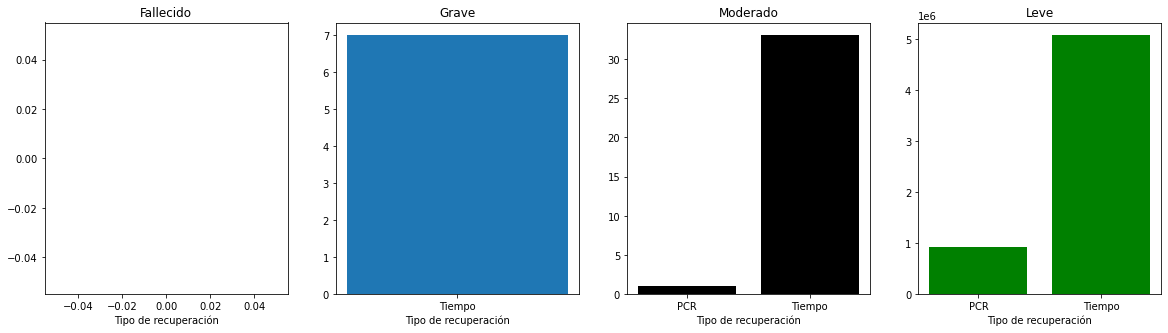

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
axs[0].bar(df[df['Estado']=='Fallecido']['Tipo de recuperación'].value_counts().sort_index().index, df[df['Estado']=='Fallecido']['Tipo de recuperación'].value_counts().sort_index(),\
     color = 'g', align='center')
axs[0].set_title('Fallecido')
axs[0].set_xlabel('Tipo de recuperación')
axs[1].bar(df[df['Estado']=='Grave']['Tipo de recuperación'].value_counts().sort_index().index, df[df['Estado']=='Grave']['Tipo de recuperación'].value_counts().sort_index(), align='center')
axs[1].set_title('Grave')
axs[1].set_xlabel('Tipo de recuperación')
# axs[1].set_xlim([0,7])
axs[2].bar(df[df['Estado']=='Moderado']['Tipo de recuperación'].value_counts().sort_index().index,df[df['Estado']=='Moderado']['Tipo de recuperación'].value_counts().sort_index(),\
     color = 'k', align='center')
axs[2].set_title('Moderado')
axs[2].set_xlabel('Tipo de recuperación')
axs[3].bar(df[df['Estado']=='Leve']['Tipo de recuperación'].value_counts().sort_index().index,df[df['Estado']=='Leve']['Tipo de recuperación'].value_counts().sort_index(), \
    color = 'g', align='center')
axs[3].set_title('Leve')
axs[3].set_xlabel('Tipo de recuperación')
plt.show()

### Diagnosis date

Bar charts bellow show patient in each state from March 2020 to July 2022. In 2022, deceased and slight cases have reduced accompanied by an increase of serious and moderate cases. This tendency is probably a consequence of higher vaccination rates as well as reduced tests per day since late 2021. Furthermore, deceased, and slight plots display four peaks during the pandemic, the latter being smaller for deceases and bigger for slight states, probably due to higher vaccination coverage, as well.

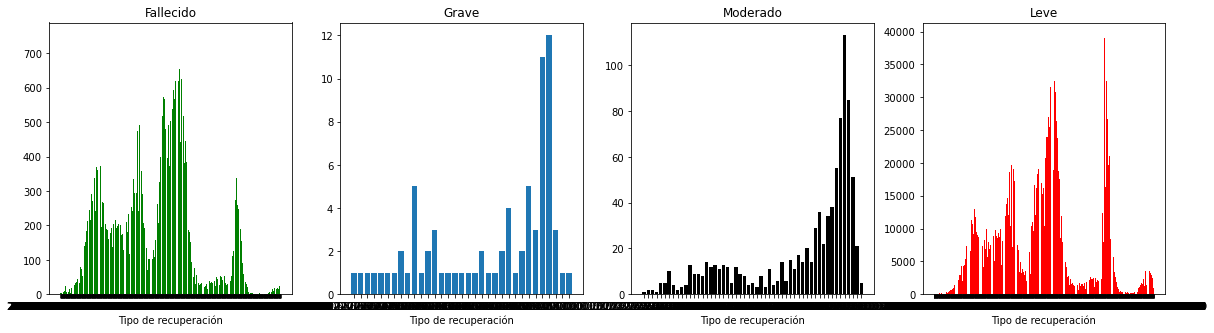

In [25]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
axs[0].bar(df[df['Estado']=='Fallecido']['Fecha de diagnóstico'].value_counts().sort_index().index, df[df['Estado']=='Fallecido']['Fecha de diagnóstico'].value_counts().sort_index(),\
     color = 'g', align='center')
axs[0].set_title('Fallecido')
axs[0].set_xlabel('Tipo de recuperación')
axs[1].bar(df[df['Estado']=='Grave']['Fecha de diagnóstico'].value_counts().sort_index().index, df[df['Estado']=='Grave']['Fecha de diagnóstico'].value_counts().sort_index(), align='center')
axs[1].set_title('Grave')
axs[1].set_xlabel('Tipo de recuperación')
# axs[1].set_xlim([0,7])
axs[2].bar(df[df['Estado']=='Moderado']['Fecha de diagnóstico'].value_counts().sort_index().index,df[df['Estado']=='Moderado']['Fecha de diagnóstico'].value_counts().sort_index(),\
     color = 'k', align='center')
axs[2].set_title('Moderado')
axs[2].set_xlabel('Tipo de recuperación')
axs[3].bar(df[df['Estado']=='Leve']['Fecha de diagnóstico'].value_counts().sort_index().index,df[df['Estado']=='Leve']['Fecha de diagnóstico'].value_counts().sort_index(), \
    color = 'r', align='center')
axs[3].set_title('Leve')
axs[3].set_xlabel('Tipo de recuperación')
plt.show()

In [26]:
df.columns

Index(['fecha reporte web', 'ID de caso', 'Fecha de notificación',
       'Código DIVIPOLA departamento', 'Código DIVIPOLA municipio', 'Edad',
       'Unidad de medida de edad', 'Sexo', 'Tipo de contagio',
       'Ubicación del caso', 'Estado', 'Código ISO del país', 'Recuperado',
       'Fecha de inicio de síntomas', 'Fecha de muerte',
       'Fecha de diagnóstico', 'Fecha de recuperación', 'Tipo de recuperación',
       'Pertenencia étnica'],
      dtype='object')

# Preprocessing

## Data types

Verifying proper data types of analysis

In [27]:
print(df.dtypes)

fecha reporte web                object
ID de caso                       object
Fecha de notificación            object
Código DIVIPOLA departamento     object
Código DIVIPOLA municipio        object
Edad                            float64
Unidad de medida de edad         object
Sexo                             object
Tipo de contagio                 object
Ubicación del caso               object
Estado                           object
Código ISO del país              object
Recuperado                       object
Fecha de inicio de síntomas      object
Fecha de muerte                  object
Fecha de diagnóstico             object
Fecha de recuperación            object
Tipo de recuperación             object
Pertenencia étnica              float64
dtype: object


In [28]:
df['fecha reporte web'] = df['fecha reporte web'].astype('string')
df['ID de caso'] = df['ID de caso'].astype('int')
df.Sexo = df.Sexo.astype('string')
df['Tipo de contagio'] = df['Tipo de contagio'].astype('string')
df['Ubicación del caso'] = df['Ubicación del caso'].astype('string')
df['Estado'] = df['Estado'].astype('string')
df['Código ISO del país'] = df['Código ISO del país'].astype('float')
df['Fecha de notificación'] = df['Fecha de notificación'].astype('string')
df['Código DIVIPOLA departamento'] = df['Código DIVIPOLA departamento'].astype('int')
df['Código DIVIPOLA municipio'] = df['Código DIVIPOLA municipio'].astype('int')
df['Unidad de medida de edad'] = df['Unidad de medida de edad'].astype('int')
df['Sexo'] = df['Sexo'].astype('string')
df['Recuperado'] = df['Recuperado'].astype('string')
df['Fecha de inicio de síntomas'] = df['Fecha de inicio de síntomas'].astype('string')
df['Fecha de muerte'] = df['Fecha de muerte'].astype('string')
df['Fecha de diagnóstico'] = df['Fecha de diagnóstico'].astype('string')
df['Fecha de recuperación'] = df['Fecha de recuperación'].astype('string')
df['Tipo de recuperación'] = df['Tipo de recuperación'].astype('string')

In [29]:
df.dtypes

fecha reporte web                string
ID de caso                        int32
Fecha de notificación            string
Código DIVIPOLA departamento      int32
Código DIVIPOLA municipio         int32
Edad                            float64
Unidad de medida de edad          int32
Sexo                             string
Tipo de contagio                 string
Ubicación del caso               string
Estado                           string
Código ISO del país             float64
Recuperado                       string
Fecha de inicio de síntomas      string
Fecha de muerte                  string
Fecha de diagnóstico             string
Fecha de recuperación            string
Tipo de recuperación             string
Pertenencia étnica              float64
dtype: object

## NaN Values

Features with more than 10% of NaNs will be dropped. Therefore, columns like "Código ISO del país" and "Fecha de muerte" where deleted.

In [30]:
df = df.dropna(axis=1, thresh=600000)

In [31]:
df.columns, df.shape

(Index(['fecha reporte web', 'ID de caso', 'Fecha de notificación',
        'Código DIVIPOLA departamento', 'Código DIVIPOLA municipio', 'Edad',
        'Unidad de medida de edad', 'Sexo', 'Tipo de contagio',
        'Ubicación del caso', 'Estado', 'Recuperado',
        'Fecha de inicio de síntomas', 'Fecha de diagnóstico',
        'Fecha de recuperación', 'Tipo de recuperación', 'Pertenencia étnica'],
       dtype='object'),
 (6197432, 17))

In [32]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6197432 entries, 0 to 6247633
Data columns (total 17 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   fecha reporte web             6197432 non-null  string 
 1   ID de caso                    6197432 non-null  int32  
 2   Fecha de notificación         6197432 non-null  string 
 3   Código DIVIPOLA departamento  6197432 non-null  int32  
 4   Código DIVIPOLA municipio     6197432 non-null  int32  
 5   Edad                          6197432 non-null  float64
 6   Unidad de medida de edad      6197432 non-null  int32  
 7   Sexo                          6197432 non-null  string 
 8   Tipo de contagio              6197432 non-null  string 
 9   Ubicación del caso            6166948 non-null  string 
 10  Estado                        6166948 non-null  string 
 11  Recuperado                    6197432 non-null  string 
 12  Fecha de inicio de síntomas 

## Standarization

Variance is different among all numerical features, and this can affect their representational power. This is also a consequence of different scales among columns, e.g., "ID de caso" varies from 6247674 to 1, while "Pertenencia étnica" from 1 to 6. Therefore, normalization and/or standardization is useful to have same scale features.

In [33]:
df.var()

ID de caso                      3.244892e+12
Código DIVIPOLA departamento    3.475289e+07
Código DIVIPOLA municipio       6.924481e+08
Edad                            3.364314e+02
Unidad de medida de edad        5.199603e-03
Pertenencia étnica              3.465249e-01
dtype: float64

In [34]:
df_subset = df[['ID de caso', 'Código DIVIPOLA departamento', 'Código DIVIPOLA municipio', 'Edad', 'Unidad de medida de edad', 'Pertenencia étnica']]

In [35]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df_sub_scaled = pd.DataFrame(ss.fit_transform(df_subset), index=df_subset.index, columns = df_subset.columns)
df_sub_scaled.var()

ID de caso                      1.0
Código DIVIPOLA departamento    1.0
Código DIVIPOLA municipio       1.0
Edad                            1.0
Unidad de medida de edad        1.0
Pertenencia étnica              1.0
dtype: float64

In [36]:
df_scaled = df.copy()
df_scaled[['ID de caso', 'Código DIVIPOLA departamento', 'Código DIVIPOLA municipio', 'Edad', 'Unidad de medida de edad', 'Pertenencia étnica']] = df_sub_scaled
df_scaled.var()

ID de caso                      1.0
Código DIVIPOLA departamento    1.0
Código DIVIPOLA municipio       1.0
Edad                            1.0
Unidad de medida de edad        1.0
Pertenencia étnica              1.0
dtype: float64

## Feature Engineering

### Categorical data

In this section categorical data is encoded to numerical values.

In [37]:
# Since NaN as a label have no meaning, rows with NaN in the "Estado" columns are dropped
df_scaled = df_scaled.dropna(subset=['Estado'])
df_scaled.shape

(6166948, 17)

In [38]:
df_cat = df_scaled.drop(['ID de caso', 'Código DIVIPOLA departamento', 'Código DIVIPOLA municipio', 'Edad', 'Unidad de medida de edad', 'Pertenencia étnica'], axis=1)
df_cat.columns

Index(['fecha reporte web', 'Fecha de notificación', 'Sexo',
       'Tipo de contagio', 'Ubicación del caso', 'Estado', 'Recuperado',
       'Fecha de inicio de síntomas', 'Fecha de diagnóstico',
       'Fecha de recuperación', 'Tipo de recuperación'],
      dtype='object')

In [39]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_scaled['Sexo'] = le.fit_transform(df_scaled.Sexo)

df_scaled.Sexo.unique()

array([1, 0])

In [40]:
for col in df_cat.columns:
    if df_scaled[col].isnull().any():
        df_scaled[col].fillna(value="None Given", inplace=True)
    
    df_scaled[col] = le.fit_transform(df_scaled[col])

df_scaled.dtypes       

fecha reporte web                 int32
ID de caso                      float64
Fecha de notificación             int32
Código DIVIPOLA departamento    float64
Código DIVIPOLA municipio       float64
Edad                            float64
Unidad de medida de edad        float64
Sexo                              int64
Tipo de contagio                  int32
Ubicación del caso                int32
Estado                            int32
Recuperado                        int32
Fecha de inicio de síntomas       int32
Fecha de diagnóstico              int32
Fecha de recuperación             int32
Tipo de recuperación              int32
Pertenencia étnica              float64
dtype: object

## Dates

In [41]:
df_scaled.dtypes

fecha reporte web                 int32
ID de caso                      float64
Fecha de notificación             int32
Código DIVIPOLA departamento    float64
Código DIVIPOLA municipio       float64
Edad                            float64
Unidad de medida de edad        float64
Sexo                              int64
Tipo de contagio                  int32
Ubicación del caso                int32
Estado                            int32
Recuperado                        int32
Fecha de inicio de síntomas       int32
Fecha de diagnóstico              int32
Fecha de recuperación             int32
Tipo de recuperación              int32
Pertenencia étnica              float64
dtype: object

In [42]:
df_scaled = df_scaled.drop(['fecha reporte web', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación'], axis=1)
df_scaled.columns

Index(['ID de caso', 'Código DIVIPOLA departamento',
       'Código DIVIPOLA municipio', 'Edad', 'Unidad de medida de edad', 'Sexo',
       'Tipo de contagio', 'Ubicación del caso', 'Estado', 'Recuperado',
       'Tipo de recuperación', 'Pertenencia étnica'],
      dtype='object')

## Dimensionality Reduction

### PCA



In [43]:
df_scaled.isnull().any()

ID de caso                      False
Código DIVIPOLA departamento    False
Código DIVIPOLA municipio       False
Edad                            False
Unidad de medida de edad        False
Sexo                            False
Tipo de contagio                False
Ubicación del caso              False
Estado                          False
Recuperado                      False
Tipo de recuperación            False
Pertenencia étnica               True
dtype: bool

In [44]:
df_scaled['Pertenencia étnica'].fillna(
    df_scaled['Pertenencia étnica'].mean(),
    inplace=True   
)

In [45]:
X = df_scaled.drop('Estado', axis = 1)
y = df_scaled[['Estado']]

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipe = Pipeline(
    [('scaler', StandardScaler()),
                 ('reducer', PCA(n_components=5, random_state = 42))]
)

df_pca = pipe.fit_transform(X)

df_pca.shape

(6166948, 5)

# Traning Models for prediction

Due to limitations in the computational power, a small sample with equally distributed labels is used to train and evaluate the models. Hence, a 925,043 entries version of the data set was used with 0.33 of the data used for testing and 67% to training. Two models where selected as candidates for evaluation: A Support Vector Machine and a Logistic Regression, given their good performance in various prediction contexts. Both models are trained using cross validation and grid search in order to optimize parameter selection.

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_pca, y, test_size = 0.15, random_state=42, stratify=y)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size = 0.33, random_state=42, stratify=y_test)

In [60]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((305265, 5), (305265, 1), (619778, 5), (619778, 1))

## SVM

In [61]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

c_vals=[1, 5, 10] 
gamma_vals=[0.1, 0.01, 0.0001, 0.00001]
param_grid = [{'C': c_vals, 'gamma': gamma_vals}]

svm = GridSearchCV(SVC(random_state=1234), param_grid, n_jobs=-1)
svm.fit(X_train, y_train)

# svm.score(X_test, y_test)


GridSearchCV(estimator=SVC(random_state=1234), n_jobs=-1,
             param_grid=[{'C': [1, 5, 10],
                          'gamma': [0.1, 0.01, 0.0001, 1e-05]}])

In [63]:
from sklearn.metrics import precision_recall_fscore_support

preds = svm.predict(X_test)

aca,recall, f1_score, support = precision_recall_fscore_support(y_test, preds, average='macro',zero_division=0)

print(aca,recall, f1_score, support)

In [64]:
print(aca,recall, f1_score, support)

0.9999631647186281 0.9944084473242141 0.9971545950344514 None


## Logistic Regression

In [67]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
c_valslr = [0.001, 0.01, 0.1, 1, 10, 100, 1000]  
pentalty = ['l1','l2']
param_grid = [{'C': c_valslr, 'penalty': pentalty}]

lg_r = GridSearchCV(LogisticRegression(random_state=1234), param_grid, n_jobs=-1)
lg_r.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(random_state=1234), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'penalty': ['l1', 'l2']}])

In [68]:
from sklearn.metrics import precision_recall_fscore_support

preds = lg_r.predict(X_test)

aca,recall, f1_score, support = precision_recall_fscore_support(y_test, preds, average='macro',zero_division=0)

print(aca,recall, f1_score, support)


0.7150867622847855 0.7232267022401229 0.7190846949058393 None


## Model comparison

Performance results in the test set are show bellow for each model:

**Support Vector Machine**
- Accuracy: 0.999
- Recall: 0.994
- f1-score: 0.997

**Logistic Regression**
- Accuracy: 0.715
- Recall: 0.723
- f1-score: 0.719

Performance indicators show that SVM approach has more representational power and therefore, is more suitable for the prediction of the state of patients in the INS dataset. With more computational power, evaluation could have been performed over the complete data set and deep learning approaches could have been tested with proven good performance architectures.
